#### Problem Statement:

Manually obtaining images of me and my family members potraying various emotions such as anger,happy,sad and shock.Further building a classification model using VGG16 network and finally recognizig the emotion of a person using the webcam. 

#### Import Libraries:

In [1]:
import cv2
import numpy as np
import split_folders
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import load_model

#### Obtaining Images using Webcam:

In [2]:
# Loading the open source Haar Classifier which is used to recognize faces.
classifier=cv2.CascadeClassifier("D:/MTech-DSML/DATA/haarcascade_frontalface_alt2.xml")

# Function to crop face from an image
def face_extractor(img):
    #Detects objects of different sizes in the input image.
    face=classifier.detectMultiScale(img,1.3,2)
    
    if face is ():
        return None
    
    # Co-ordinates of face
    for (x,y,w,h) in face:
        x=x-10
        y=y-10
        cropped_face=img[y:y+h+150,x:x+w+150]
        
    return cropped_face

In [ ]:
# Initializing the Webcam
capture=cv2.VideoCapture(0)
count=0

#Collecting 200 images of each expression
while True:
    ret,frame=capture.read()
    if face_extractor(frame) is not None:
        count +=1
        # Resizing the image
        face=cv2.resize(face_extractor(frame),(400,400))
        # Saving the images in a specific path
        file_path="D:/MTech-DSML/Main Projects/ Emotion Images/Shock/"+str(count)+'.jpg'
        cv2.imwrite(file_path,face)
        cv2.imshow("Face Crop",face)
    else:
        # Incase the face in not found in the frame
        print("Face not found")
        pass
    
    # Wait until Enter key is pressed (13) or until 200 images are obtained
    if cv2.waitKey(1)== 13 or count==200:
        break
        
capture.release()
cv2.destroyAllWindows()
print("200 images of the class collected")
    
        

200 images of each emotion class i.e  anger,happy,sad and shock has been collected and will be used further for building a classification model

#### Loading the data:

In [3]:
# Splitting Data into Train and Validation
split_folders.ratio("D:/MTech-DSML/Main Projects/Emotion Images",output="D:/MTech-DSML/Main Projects/Emotion Images Split",
                   seed=1337,
                  ratio=(0.8, 0.2))

Copying files: 800 files [00:00, 1610.05 files/s]


In [4]:
# Train data Augmentation
train_datagen=ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_data=train_datagen.flow_from_directory("D:/MTech-DSML/Main Projects/Emotion Images Split/train",target_size=(64,64),class_mode='categorical',
    batch_size=16)

Found 640 images belonging to 4 classes.


In [5]:
val_datagen=ImageDataGenerator(rescale=1./255)

val_data=val_datagen.flow_from_directory("D:/MTech-DSML/Main Projects/Emotion Images Split/val",target_size=(64, 64),class_mode='categorical',
    batch_size=16)

Found 160 images belonging to 4 classes.


#### Building Classification Model using VGG16:

In [6]:
model=VGG16()

In [7]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
# Excluding the Convolution layers of the VGG16 model and setting the input shape same as that of target size during Data Augmentation
model=VGG16(input_shape=(64,64,3),include_top=False)

In [9]:
# Train the weights of only the dense layers 
for layers in model.layers:
    if('dense' not in layers.name):
        layers.trainable=False
    if('dense' in layers.name):
        layers.trainable=True

In [10]:
#Adding the new dense layers to the VGG16 model
transfer_model=Sequential([model,
                          Flatten(),
                          Dense(64,activation='relu'),
                          Dense(4,activation='softmax')])
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 14,846,084
Trainable params: 131,396
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
#Compiling the model using adam optimizer, loss as 'categorical_crossentropy' and metrics as accuracy
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
my_model=transfer_model.fit_generator(train_data,steps_per_epoch=640 //16,epochs=50,
                                      validation_data=val_data,validation_steps=160//16)

C:\Users\acer\.conda\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
40/40 [==============================] - 13s 313ms/step - loss: 0.4999 - accuracy: 0.8469 - val_loss: 0.1716 - val_accuracy: 0.9688
Epoch 2/50
40/40 [==============================] - 9s 238ms/step - loss: 0.1154 - accuracy: 0.9781 - val_loss: 0.0677 - val_accuracy: 0.9875
Epoch 3/50
40/40 [==============================] - 9s 231ms/step - loss: 0.0633 - accuracy: 0.9844 - val_loss: 0.0349 - val_accuracy: 0.9937
Epoch 4/50
40/40 [==============================] - 10s 239ms/step - loss: 0.0405 - accuracy: 0.9922 - val_loss: 0.0293 - val_accuracy: 0.9875
Epoch 5/50
40/40 [==============================] - 9s 231ms/step - loss: 0.0331 - accuracy: 0.9922 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 6/50
40/40 [==============================] - 9s 216ms/step - loss: 0.0283 - accuracy: 0.9953 - val_loss: 0.0164 - val_accuracy: 0.9937
Epoch 7/50
40/40 [==============================] - 9s 218ms/step - loss: 0.0346 - accuracy: 0.9906 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoc

In [15]:
transfer_model.save("emotion_detection.h5")

In [16]:
train_data.class_indices

{'Anger': 0, 'Happy': 1, 'Sad': 2, 'Shock': 3}

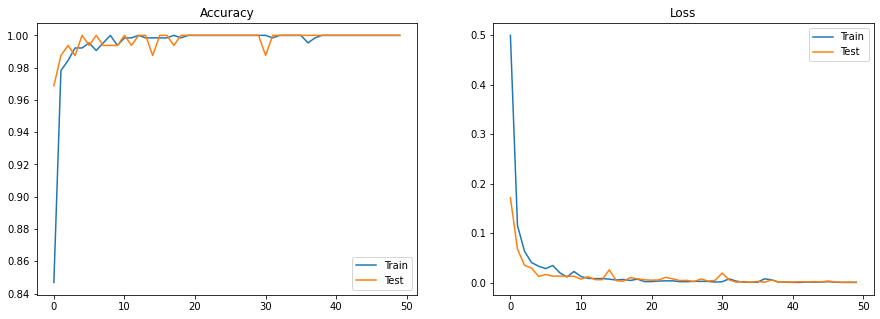

In [17]:
# Comparing performance metrics of the model
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(my_model.history['accuracy'],label='Train')
plt.plot(my_model.history['val_accuracy'],label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(my_model.history['loss'],label='Train')
plt.plot(my_model.history['val_loss'],label='Test')
plt.title("Loss")
plt.legend()
plt.show()

#### Predicting the emotions using Webcam:

In [18]:
# Loading the model weights which were trained
model=load_model("emotion_detection.h5")

In [ ]:
# Initialising Webcam to read and predict the emotions
video_capture = cv2.VideoCapture(0)
while True:
    _,frame = video_capture.read()
    
    emotion=face_extractor(frame)
    if type(emotion) is np.ndarray:
        # Resizing image to the size required by the model
        emotion = cv2.resize(emotion, (64,64))
        im = Image.fromarray(emotion, 'RGB')
        img_array = np.array(im)
        img_array = np.expand_dims(img_array, axis=0)
        pred = model.predict(img_array)
        print(pred)
        
        # In case an emotion which was not trained is used
        name="None matching"
        
        if(pred[0][0]>0.5):
            name='Anger'
        elif (pred[0][1]>0.5) :
            name='Happy'
        elif (pred[0][2]>0.5) :
            name='Sad' 
        elif (pred[0][3]>0.5) :
            name='Shock'
        cv2.putText(frame,name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    else:
        cv2.putText(frame,"No expression", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

#### Conclusion:

- The model was able to accurately recognise each of the emotions from the person captured by the webcam 
